# Gradient Boosted Trees

**Table of Contents**
- [1. Introduction](#1-introduction)
    - [1.1. Prerequisites](#11-prerequisites)
- [2. Tuning Parameters](#2-tuning-parameters)
    - [2.1. Strategy](#21-strategy)
- [3. Evaluation of Performance of Tuned Gradient Boosted Tree](#3-evaluation-of-performance-of-tuned-gradient-boosted-tree)
- [4. Conclusion](#4-conclusion)
- [5. References](#5-references)

## 1. Introduction

Gradient boosted trees are an ensemble of tree predictors where trees are built sequentially, with each new tree attempting to correct the errors made by the previous ones [1]. In this approach, each tree contributes to the final prediction by minimizing a loss function, and the ensemble prediction is obtained by a weighted vote of the predictions from all trees. 

To enhance accuracy, gradient boosting focuses on reducing the bias of the model by fitting new trees to the residuals of the predictions from the existing ensemble. Unlike random forests, which introduce randomness through methods like bootstrapping or feature selection, gradient boosting relies on gradient descent to optimize the ensemble's performance. The method can also incorporate regularization techniques to prevent overfitting, such as limiting the depth of the trees or applying shrinkage to the contribution of each tree. In this text, we will primarily focus on optimising parameters such as the number of leaves, the maximum depth of each tree, the learning rate and the number of trees used. 

## 1.1 Prerequisites

We load the data and prequisites below. 

In [1]:
import subprocess
import sys

# List of required packages
required_packages = [
    'pandas',  # Data manipulation and analysis
    'numpy',  # Numerical operations
    'matplotlib',  # Data visualization
    'seaborn',  # Statistical data visualization
    'lightgbm',  # LightGBM for gradient boosting
    'scikit-learn',  # Machine learning library
]

# Function to check and install packages
def install(package):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

# Check and install required packages
for package in required_packages:
    try:
        __import__(package)
        print(f"'{package}' is already installed.")
    except ImportError:
        print(f"'{package}' not found. Installing...")
        install(package)

print("\nAll required packages are checked/installed.")

'pandas' is already installed.
'numpy' is already installed.
'matplotlib' is already installed.
'seaborn' is already installed.
'lightgbm' is already installed.
'scikit-learn' not found. Installing...

All required packages are checked/installed.


In [2]:
import os  # Operating system functionalities
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations
import pickle  # Object serialization
import lightgbm as lgb  # LightGBM for gradient boosting
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Statistical data visualization

from sklearn.impute import SimpleImputer  # For single imputation of missing values
from sklearn.model_selection import RandomizedSearchCV  # Randomized hyperparameter search
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc  # Model evaluation metrics

In [3]:
# Load the saved datasets from the CSV files
X_train_smote = pd.read_csv("../data/X_train_smote.csv", index_col=0)
y_train_smote = pd.read_csv("../data/y_train_smote.csv", index_col=0)
X_test = pd.read_csv("../data/X_test.csv", index_col=0)
y_test = pd.read_csv("../data/y_test.csv", index_col=0)

# Convert categorical columns to numeric codes
def encode_categorical(X):
    return X.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

X_train_smote_encoded = encode_categorical(X_train_smote)
X_test_encoded = encode_categorical(X_test)

# 2. Tuning parameters

## 2.1 Strategy
This section will focus on tuning the hyperparameters of the gradient boosted trees model for classification. Since there are many hyperparameters to consider, we will perform a grid-based search using cross-validation, considering the following parameters:
> - 'num_leaves': np.arange(20, 150, 10),
>  - 'max_depth': [-1] + list(np.arange(5, 25, 5)),
>  - 'learning_rate': [0.01, 0.05, 0.1, 0.2],
>  - 'n_estimators': np.arange(100, 1001, 100),

Even though we have not defined a very fine grid, optimising over this set by exhaustive search is time-consuming. Hence we will use randomised search.

In [4]:
# Define the model
model = lgb.LGBMClassifier(random_state=42)  # Set the random state for reproducibility

# Perform single imputation to handle missing data
imputer = SimpleImputer(strategy='most_frequent')
X_train_smote_imputed = pd.DataFrame(imputer.fit_transform(X_train_smote_encoded), columns=X_train_smote_encoded.columns)

# File to store the best parameters
params_file = "pickle/best_params.pkl"

# Check if the parameters file exists
if os.path.exists(params_file):
    # Load the best parameters from the pickle file
    with open(params_file, 'rb') as f:
        best_params = pickle.load(f)
    print("Loaded best parameters: ", best_params)
else:
    # Set up the parameter grid for tuning
    param_distributions = {
        'num_leaves': np.arange(20, 150, 10),
        'max_depth': [-1] + list(np.arange(5, 25, 5)),
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': np.arange(100, 1001, 100),
    }

    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                       n_iter=20, scoring='accuracy', cv=5, verbose=1, n_jobs=-1,
                                       random_state=42)  # Set random_state for reproducibility

    # Fit the model
    random_search.fit(X_train_smote_imputed, y_train_smote.values.ravel())

    # Get the best parameters
    best_params = random_search.best_params_
    print("Best parameters found: ", best_params)

    # Save the best parameters to a pickle file
    with open(params_file, 'wb') as f:
        pickle.dump(best_params, f)

Loaded best parameters:  {'num_leaves': 90, 'n_estimators': 1000, 'max_depth': 20, 'learning_rate': 0.05}


## 3. Evaluation of Performance of Tuned Gradient Boosted Tree

We use the best parameters we found, and evaluate the performance.

Loaded best parameters:  {'num_leaves': 90, 'n_estimators': 1000, 'max_depth': 20, 'learning_rate': 0.05}
[LightGBM] [Info] Number of positive: 30293, number of negative: 30293
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 60586, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


C:\Users\megar\AppData\Local\Temp\ipykernel_25288\3411310215.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_numeric = pd.Series(y_test.values.ravel()).replace({'<=50K': 0, '>50K': 1})


AUC-ROC Score: 0.89


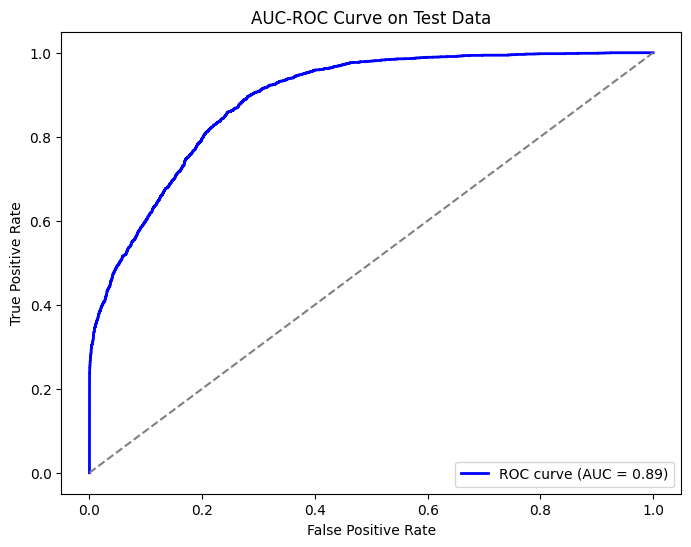

Accuracy on test set:  0.7362152624614028
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.96      0.68      0.80      6862
        >50K       0.48      0.92      0.63      2206

    accuracy                           0.74      9068
   macro avg       0.72      0.80      0.71      9068
weighted avg       0.85      0.74      0.75      9068



In [5]:
# Define the model
model = lgb.LGBMClassifier(random_state=42)  # Set the random state for reproducibility

# File to store the best parameters
params_file = "pickle/best_params.pkl"
auc_file = "pickle/gbm_roc_data.pkl"  # File to store the AUC score

# Check if the parameters file exists
if os.path.exists(params_file):
    # Load the best parameters from the pickle file
    with open(params_file, 'rb') as f:
        best_params = pickle.load(f)
    print("Loaded best parameters: ", best_params)
else:
    # Set up the parameter grid for tuning
    param_distributions = {
        'num_leaves': np.arange(20, 150, 10),
        'max_depth': [-1] + list(np.arange(5, 25, 5)),
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': np.arange(100, 1001, 100),
    }

    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                       n_iter=25, scoring='accuracy', cv=5, verbose=1, n_jobs=-1,
                                       random_state=42)  # Set random_state for reproducibility

    # Fit the model
    random_search.fit(X_train_smote_encoded, y_train_smote)

    # Get the best parameters
    best_params = random_search.best_params_
    print("Best parameters found: ", best_params)

    # Save the best parameters to a pickle file
    with open(params_file, 'wb') as f:
        pickle.dump(best_params, f)

# Create and train the best model with the best parameters
best_model = lgb.LGBMClassifier(**best_params, random_state=42)  # Set random state for reproducibility
best_model.fit(X_train_smote_encoded, y_train_smote.values.ravel())

# Make predictions on the test set
y_pred = best_model.predict(X_test_encoded)
y_pred_proba = best_model.predict_proba(X_test_encoded)[:, 1]  # Get probabilities for the positive class

# Convert actual income in y_test to numeric if necessary
y_test_numeric = pd.Series(y_test.values.ravel()).replace({'<=50K': 0, '>50K': 1})

# Calculate AUC-ROC score on the test dataset
auc_score = roc_auc_score(y_test_numeric, y_pred_proba)
print(f"AUC-ROC Score: {auc_score:.2f}")

# Plot AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Save AUC score to a file
# Save ROC data to a file
roc_data = {
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': auc_score
}
with open(auc_file, 'wb') as f:
    pickle.dump(roc_data, f)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve on Test Data')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy seems poor. It is even worse than just predicting everything as the majority class (this would give an accuracy equal to the no information rate seen in Section 5.2, which is 6862/(6862+2206) = 0.7567) and in particular the precision for high income individuals is very low. The AUC is the same as we saw for the random forests (to 2 decimal places)! We can see through the other numbers in the classification report that the classifiers are quite different. We elucidate this by considering income predictions by sex.

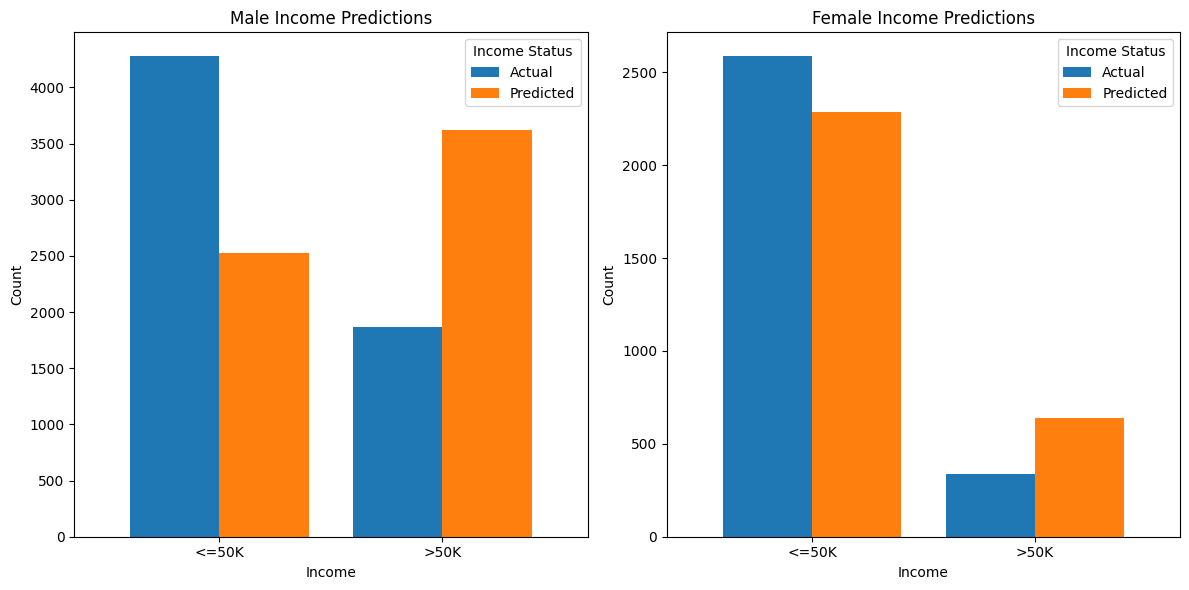

In [6]:
# Create a DataFrame for easier plotting of actual vs predicted income by sex
results_df = pd.DataFrame({
    'Predicted Income': y_pred,
    'Actual Income': y_test.values.ravel(),
    'Sex': X_test["sex"]
})

# Filter for males and females
male_df = results_df[results_df['Sex'] == 'Male']
female_df = results_df[results_df['Sex'] == 'Female']

# Count occurrences for males
male_actual_counts = male_df['Actual Income'].value_counts()
male_predicted_counts = male_df['Predicted Income'].value_counts()

# Count occurrences for females
female_actual_counts = female_df['Actual Income'].value_counts()
female_predicted_counts = female_df['Predicted Income'].value_counts()

# Create a DataFrame to hold counts for males
male_income_counts = pd.DataFrame({
    'Actual': male_actual_counts,
    'Predicted': male_predicted_counts
}).fillna(0)

# Create a DataFrame to hold counts for females
female_income_counts = pd.DataFrame({
    'Actual': female_actual_counts,
    'Predicted': female_predicted_counts
}).fillna(0)

# Create side-by-side bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Male plot
male_income_counts.plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e'], width=0.8)
axes[0].set_title('Male Income Predictions')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Income')
axes[0].set_xticklabels(male_income_counts.index, rotation=0)
axes[0].legend(title='Income Status', loc='upper right')

# Female plot
female_income_counts.plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e'], width=0.8)
axes[1].set_title('Female Income Predictions')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Income')
axes[1].set_xticklabels(female_income_counts.index, rotation=0)
axes[1].legend(title='Income Status', loc='upper right')

plt.tight_layout()
plt.show()

Similar to what we saw using random forests, the female predictions are better than those for males, despite the fact that there were much fewer females in the dataset. For low-income males, there is a tendency to predict them to be high-income, leading to a disparity between actual and predicted counts. We also see this for low-income females, though to a lesser extent.

# 4. Conclusion

We have used gradient boosted machines (GBM) to perform predictions. We employed a randomized grid search to optimize the hyperparameters.

The results indicated that our model performed worse than the random forest. It has a worse accuracy than the classifier predicting everything as the majority class. To extend this analysis, it would be beneficial to conduct a finer grid search and consider using exhaustive search rather than randomized search. 

# 5. References

[1] Natekin, Alexey, and Alois Knoll. "Gradient boosting machines, a tutorial." Frontiers in neurorobotics 7 (2013): 21.

[2] LightGBM source: https://github.com/microsoft/LightGBM

[3] Accessible tutorial: https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/